# Банки — Анализ оттока клиентов

## Задача:

Маркетинговый отдел из “Метанпромбанка” провел исследование оттока клиентов. Были составлены дэшборды и выделены сегменты, но клиентская база поменялась, и текущие решения не работают.

Необходимо проанализировать клиентов регионального банка и выделить сегменты клиентов, которые склонны уходить из банка. И дать рекомендации по снижению оттока.

### Описание датасетов

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

**Колонки**:
 - `userid` — идентификатор пользователя,
 - `score` — баллы кредитного скоринга,
 - `City` — город,
 - `Gender` — пол,
 - `Age` — возраст,
 - `Objects` — количество объектов в собственности
`/ equity` — количество баллов собственности
 - `Balance` — баланс на счёте,
 - `Products` — количество продуктов, которыми пользуется клиент,
 - `CreditCard` — есть ли кредитная карта,
 - `Loyalty / last_activity` — активный клиент,
 - `estimated_salary` — заработная плата клиента,
 -`Churn` — ушёл или нет.

### Данные:
bank_scrooge.csv

## Описание проекта:

**Главная задача** - Выделить сегмент оттока, который будет выше среднего оттока по банку - его будем считать успешным сегментом.

## 1. Загрузка и описание данных.

In [1]:
# Выгрузим все необходымые для работы библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math
import plotly.express as px
import plotly.graph_objs as go
import warnings
from scipy.stats import mannwhitneyu
from statistics import *

In [2]:
warnings.filterwarnings("ignore")

In [3]:
path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F" 
data = pd.read_csv(path)

In [4]:
data

USERID  score       city gender   age  equity     balance  products  \
0     183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
1     146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
2     120722  892.0    Рыбинск      Ж  30.0       0         NaN         1   
3     225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4     157978  730.0  Ярославль      М  34.0       5      174.00         1   
...      ...    ...        ...    ...   ...     ...         ...       ...   
9995  120553  814.0    Рыбинск      М  27.0       1    78144.65         1   
9996  139170  894.0  Ярославль      М  46.0       0         NaN         1   
9997  115639  903.0  Ярославль      М  24.0       0         NaN         2   
9998  148700  777.0  Ярославль      Ж  68.0       3   865457.97         3   
9999   96267  828.0    Рыбинск      Ж  58.0       3  1180886.70         4   

      credit_card  last_activity  EST_SALARY  churn  
0               0              1    75719.14      1  
1               1              0    86621.77      0  
2               1              1   107683.34      0  
3               0              1   174423.53      1  
4               1              0    67353.16      1  
...           ...            ...         ...    ...  
9995            0              1    18943.64      0  
9996            1              0   196898.29      0  
9997            1              1   108905.09      0  
9998            0              1    86874.90      0  
9999            0              1    21422.37      0  

[10000 rows x 12 columns]

In [5]:
def info_date(data):
    print('**Общая информация датафрейма**')
    print(data.info(memory_usage='deep'))
    print('-------------------------------------------------------------------------------------------------------------')
    print('**Просмотр статистических данных**')
    display(data.describe())
    print('-------------------------------------------------------------------------------------------------------------')
    print('**Вывод количесва дубликатов датафрейма**')
    display(data[data.duplicated(keep=False)])
    print('-------------------------------------------------------------------------------------------------------------')
    print('**Вывод количесва пропущеных значений датафрейма**')
    display(data.isnull().sum())
      
    
display(info_date(data))


**Общая информация датафрейма**
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 2.5 MB
None
-------------------------------------------------------------------------------------------------------------
**Просмотр статистических данных**


USERID         score          age        equity       balance  \
count   10000.00000  10000.000000  9974.000000  10000.000000  7.705000e+03   
mean   171814.71260    848.699400    42.734409      2.627600  8.277943e+05   
std     33708.23812     65.448519    12.179971      1.980836  1.980614e+06   
min     94561.00000    642.000000    18.000000      0.000000  0.000000e+00   
25%    142810.25000    802.000000    33.000000      0.000000  2.955542e+05   
50%    172728.00000    853.000000    40.000000      3.000000  5.242722e+05   
75%    201261.75000    900.000000    51.000000      4.000000  9.807058e+05   
max    229145.00000   1000.000000    86.000000      9.000000  1.191136e+08   

           products   credit_card  last_activity    EST_SALARY         churn  
count  10000.000000  10000.000000   10000.000000  1.000000e+04  10000.000000  
mean       1.870100      0.680400       0.523500  1.478669e+05      0.182000  
std        0.792647      0.466345       0.499472  1.393885e+05      0.385864  
min        0.000000      0.000000       0.000000  2.546300e+03      0.000000  
25%        1.000000      0.000000       0.000000  7.525190e+04      0.000000  
50%        2.000000      1.000000       1.000000  1.196581e+05      0.000000  
75%        2.000000      1.000000       1.000000  1.745005e+05      0.000000  
max        5.000000      1.000000       1.000000  1.395064e+06      1.000000

-------------------------------------------------------------------------------------------------------------
**Вывод количесва дубликатов датафрейма**


Empty DataFrame
Columns: [USERID, score, city, gender, age, equity, balance, products, credit_card, last_activity, EST_SALARY, churn]
Index: []

-------------------------------------------------------------------------------------------------------------
**Вывод количесва пропущеных значений датафрейма**


USERID              0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
EST_SALARY          0
churn               0
dtype: int64

None

После вывода первичной информации можно сделать вывод, что:

1) Не все типы данных корректны:
  - `City` необходимо перевести в количественные данные
  - `gender` необходимо перевести в количественные данные
  - `age` необходимо перевести в `int`
  
2) Датафрейм нагружен на 2.7Мб - приемлемо

3) Явных дубликатов не выявлено

4) Есть пропущенные значения в колонках `age` и `balance`

5) Необходимо привести данные к нижнему регистру
    

## 2. Подготовка данных

In [6]:
data.columns = data.columns.str.lower()
data = data.rename(columns={"userid": "user_id"})

In [7]:
data

user_id  score       city gender   age  equity     balance  products  \
0      183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
1      146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
2      120722  892.0    Рыбинск      Ж  30.0       0         NaN         1   
3      225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4      157978  730.0  Ярославль      М  34.0       5      174.00         1   
...       ...    ...        ...    ...   ...     ...         ...       ...   
9995   120553  814.0    Рыбинск      М  27.0       1    78144.65         1   
9996   139170  894.0  Ярославль      М  46.0       0         NaN         1   
9997   115639  903.0  Ярославль      М  24.0       0         NaN         2   
9998   148700  777.0  Ярославль      Ж  68.0       3   865457.97         3   
9999    96267  828.0    Рыбинск      Ж  58.0       3  1180886.70         4   

      credit_card  last_activity  est_salary  churn  
0               0              1    75719.14      1  
1               1              0    86621.77      0  
2               1              1   107683.34      0  
3               0              1   174423.53      1  
4               1              0    67353.16      1  
...           ...            ...         ...    ...  
9995            0              1    18943.64      0  
9996            1              0   196898.29      0  
9997            1              1   108905.09      0  
9998            0              1    86874.90      0  
9999            0              1    21422.37      0  

[10000 rows x 12 columns]

In [8]:
data['gender_new'] = data['gender'].replace('Ж','0').replace('М','1').astype('int')

In [9]:
# Посмотрим более детально на пропуски 

print('Всего пропусков в столбце balance: {}'.format(data.isna().sum().sort_values(ascending=False)[0]))
print('Пропущено {}% значений в столбце balance'.format((data.isna().sum().sort_values(ascending=False)[0])*100/len(data)))
print()
print('Всего пропусков в столбце age: {}'.format(data.isna().sum().sort_values(ascending=False)[1]))
print('Пропущено {}% значений в столбце age'.format((data.isna().sum().sort_values(ascending=False)[1])*100/len(data)))

Всего пропусков в столбце balance: 2295
Пропущено 22.95% значений в столбце balance

Всего пропусков в столбце age: 26
Пропущено 0.26% значений в столбце age


Данные по столбцу `age` можно убрать, они менее `1%`

In [10]:
data = data.dropna(subset=['age'])

In [11]:
data['age'] = data['age'].astype('int')

In [12]:
# Посмотрим более детально на пропуски 
print('Всего пропусков в столбце balance: {}'.format(data.isna().sum().sort_values(ascending=False)[0]))
print('Пропущено {}% значений в столбце balance'.format(round((data.isna().sum().sort_values(ascending=False)[0])*100/len(data)),3))
print()
print('Всего пропусков в столбце age: {}'.format(data.isna().sum().sort_values(ascending=False)[1]))
print('Пропущено {}% значений в столбце age'.format((data.isna().sum().sort_values(ascending=False)[1])*100/len(data)))

Всего пропусков в столбце balance: 2279
Пропущено 23% значений в столбце balance

Всего пропусков в столбце age: 0
Пропущено 0.0% значений в столбце age


In [13]:
balance_null = data[data['balance'].isna()]

In [14]:
balance_null_2 = balance_null.pivot_table(index=['city','gender','churn','last_activity'], values = 'user_id',aggfunc='count').reset_index()

In [15]:
balance_null_2

city gender  churn  last_activity  user_id
0      Ростов      Ж      0              0       49
1      Ростов      Ж      0              1       61
2      Ростов      М      0              0       51
3      Ростов      М      0              1       73
4      Ростов      М      1              0        1
5     Рыбинск      Ж      0              0      114
6     Рыбинск      Ж      0              1      153
7     Рыбинск      Ж      1              0        1
8     Рыбинск      Ж      1              1        1
9     Рыбинск      М      0              0      142
10    Рыбинск      М      0              1      173
11    Рыбинск      М      1              0        1
12    Рыбинск      М      1              1        1
13  Ярославль      Ж      0              0      300
14  Ярославль      Ж      0              1      327
15  Ярославль      Ж      1              0        1
16  Ярославль      М      0              0      362
17  Ярославль      М      0              1      461
18  Ярославль      М      1              0        6
19  Ярославль      М      1              1        1

Даже при условии грубой группировке данных, видим, что пропущенные значения в основном у клиентов, которые остались в банке

Счтаю, что пропуски не случайны, без глубокого анализа отбрасывать их нельзя, поэтому оставим их как есть. Выдвину теорию, что у клиента есть прлдукты банка, но при открытии счет был пустой и инфо не обновилось, тк произошел рассинхрон в заполнении полей.

### Проверим данные на выбросы

In [16]:
data.head()

user_id  score       city gender  age  equity     balance  products  \
0   183012  850.0    Рыбинск      Ж   25       1    59214.82         2   
1   146556  861.0    Рыбинск      Ж   37       5   850594.33         3   
2   120722  892.0    Рыбинск      Ж   30       0         NaN         1   
3   225363  866.0  Ярославль      Ж   51       5  1524746.26         2   
4   157978  730.0  Ярославль      М   34       5      174.00         1   

   credit_card  last_activity  est_salary  churn  gender_new  
0            0              1    75719.14      1           0  
1            1              0    86621.77      0           0  
2            1              1   107683.34      0           0  
3            0              1   174423.53      1           0  
4            1              0    67353.16      1           1

In [17]:
fig = px.box(data, x='balance',color='churn')
fig.update_layout(title='Распределение баланса клиентов в разрезе оттока',
                   xaxis_title='Баланс',
                   yaxis_title='Количество',
                  title_font_size=15,
                  title_x=0.5)
    
fig.show()

Есть аномальные значения в балансе, но аномальные одни стороны, в банке клиенты делятся на сегменты:
1) Обычные

2) Privat

3) Premium 

Нельзья отсекать данные значения, тк по ним в дальнешем можно составлять портрет клиентов.

In [18]:
fig = px.histogram(data, x="age", color = 'churn')
fig.update_layout(title='Распределение возраста клиентов в разрезе оттока',
                   xaxis_title='Возраст',
                   yaxis_title='Количество',
                  title_font_size=15,
                  title_x=0.5)
fig.show()

Здесь все в порядке, выбросов не наблюдается.

In [19]:
fig = px.histogram(data, x="est_salary", color = 'churn')
fig.update_layout(title='Распределение зарплаты клиентов в разрезе оттока',
                   xaxis_title='Зарплата',
                   yaxis_title='Количество',
                  title_font_size=15,
                  title_x=0.5)
fig.show()

In [20]:
fig = px.box(data, x='est_salary',color='churn')
   
fig.update_layout(title='Распределение зарплаты клиентов в разрезе оттока',
                   xaxis_title='Зарплата',
                   yaxis_title='Количество',
                  title_font_size=15,
                  title_x=0.5)
fig.show()

Опять же нельзя однозначно сказать, что это аномалии, скорее всего это клиенты премиум сегмента. Мы либо совсем отсекаем их, либо работаем с ними и составляем под них портрет премиум клиентов. Но в любом случае, эти аномалии повлияют на наши исследования - уберем их.

In [21]:
data = data.query('est_salary < 500000 & balance <500000')

In [22]:
fig = px.box(data, x='est_salary',color='churn')
   
fig.update_layout(title='Распределение зарплаты клиентов в разрезе оттока',
                   xaxis_title='Зарплата',
                   yaxis_title='Количество',
                  title_font_size=15,
                  title_x=0.5)
fig.show()

In [23]:
fig = px.box(data, x='balance',color='churn')
fig.update_layout(title='Распределение баланса клиентов в разрезе оттока',
                   xaxis_title='Баланс',
                   yaxis_title='Количество',
                  title_font_size=15,
                  title_x=0.5)
    
fig.show()

### Кодирование

In [24]:
data['city_new'] = data['city']

In [25]:
data = pd.get_dummies(data, columns=['city'])

In [26]:
data.head()

user_id  score gender  age  equity    balance  products  credit_card  \
0    183012  850.0      Ж   25       1   59214.82         2            0   
4    157978  730.0      М   34       5     174.00         1            1   
6    177259  807.0      Ж   39       3  405042.44         3            0   
7    218868  825.0      Ж   38       4  458145.40         2            1   
13   166357  837.0      Ж   28       4  302249.22         2            0   

    last_activity  est_salary  churn  gender_new   city_new  city_Ростов  \
0               1    75719.14      1           0    Рыбинск            0   
4               0    67353.16      1           1  Ярославль            0   
6               1   103838.32      0           0  Ярославль            0   
7               1    68085.48      0           0  Ярославль            0   
13              1    30950.94      0           0    Рыбинск            0   

    city_Рыбинск  city_Ярославль  
0              1               0  
4              0               1  
6              0               1  
7              0               1  
13             1               0

## 3. EDA

### 3.1 Распределение средних значений

Судя по средним распределениям, клиенты, которые склонны к оттоку:
- мужчины
- 41 год
- склонны к активности
- имеют более 2х продуктов в банке
- в основном из Ярославля

### 3.2 Процент общего оттока

In [27]:
data.head()

user_id  score gender  age  equity    balance  products  credit_card  \
0    183012  850.0      Ж   25       1   59214.82         2            0   
4    157978  730.0      М   34       5     174.00         1            1   
6    177259  807.0      Ж   39       3  405042.44         3            0   
7    218868  825.0      Ж   38       4  458145.40         2            1   
13   166357  837.0      Ж   28       4  302249.22         2            0   

    last_activity  est_salary  churn  gender_new   city_new  city_Ростов  \
0               1    75719.14      1           0    Рыбинск            0   
4               0    67353.16      1           1  Ярославль            0   
6               1   103838.32      0           0  Ярославль            0   
7               1    68085.48      0           0  Ярославль            0   
13              1    30950.94      0           0    Рыбинск            0   

    city_Рыбинск  city_Ярославль  
0              1               0  
4              0               1  
6              0               1  
7              0               1  
13             1               0

In [28]:
data_chrn = (data.pivot_table(index='churn', values='last_activity', aggfunc='count')
             .rename(columns={'last_activity':'count'})).reset_index()
data_chrn['percent'] = round((data_chrn['count'] / data_chrn['count'].sum() *100),2)
data_chrn

churn  count  percent
0      0   3073    83.32
1      1    615    16.68

In [29]:
fig = px.pie(data_chrn, values='count', names='churn')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide',
                  title = 'Cоотношение оттока клиентов',
                  title_font_size=15,
                  title_x=0.5)
fig.show()

`17%` клиентов из банка ушли, давольно печальный показатель

### 3.3 Анализ портрета клиентов

In [30]:
data_client = data[['score','age','balance','est_salary']]

In [31]:
data_client


score  age    balance  est_salary
0     850.0   25   59214.82    75719.14
4     730.0   34     174.00    67353.16
6     807.0   39  405042.44   103838.32
7     825.0   38  458145.40    68085.48
13    837.0   28  302249.22    30950.94
...     ...  ...        ...         ...
9987  783.0   61  387916.16    63160.96
9991  840.0   44  326619.71   157589.59
9992  813.0   48  179765.62   133972.11
9994  851.0   42  370912.79   102123.93
9995  814.0   27   78144.65    18943.64

[3688 rows x 4 columns]

In [32]:
for col in data_client.columns:
    fig = px.histogram(data, x= col, color = 'churn', nbins = 70, histnorm='probability',barmode ='overlay')
    fig.update_layout(title='Распределение данных по столбцу: ' +col,
                   xaxis_title=col,
                   yaxis_title='Count',
                  title_font_size=15,
                  title_x=0.5)
                 #height=500,
                 #width=800)

    fig.show()

In [33]:
data_equity_share = data.pivot_table(index=['equity'],values='products', aggfunc='count').reset_index()
data_equity_share = data_equity_share.rename(columns={'products':'count_total'})

data_equity = data.pivot_table(index=['equity','churn'],values='products', aggfunc='count').reset_index()
data_equity['churn'] = data_equity['churn'].astype(str)
data_equity = data_equity.rename(columns={'products':'count'})

data_equity = data_equity.merge(data_equity_share, how='left', on='equity')
data_equity['percent'] = round((data_equity['count'] / data_equity['count_total'] *100),2)
data_equity = data_equity.drop('count_total', axis=1)


In [34]:
data_products_share = data.pivot_table(index=['products'],values='equity', aggfunc='count').reset_index()
data_products_share = data_products_share.rename(columns={'equity':'count_total'})

data_products = data.pivot_table(index=['products','churn'],values='equity', aggfunc='count').reset_index()
data_products['churn'] = data_equity['churn'].astype(str)
data_products = data_products.rename(columns={'equity':'count'})

data_products = data_products.merge(data_products_share, how='left', on='products')
data_products['percent'] = round((data_products['count'] / data_products['count_total'] *100),2)
data_products = data_products.drop('count_total', axis=1)

In [35]:
data_credit_card_share = data.pivot_table(index=['credit_card'],values='equity', aggfunc='count').reset_index()
data_credit_card_share = data_credit_card_share.rename(columns={'equity':'count_total'})

data_credit_card = data.pivot_table(index=['credit_card','churn'],values='equity', aggfunc='count').reset_index()
data_credit_card['churn'] = data_equity['churn'].astype(str)
data_credit_card = data_credit_card.rename(columns={'equity':'count'})

data_credit_card = data_credit_card.merge(data_credit_card_share, how='left', on='credit_card')
data_credit_card['percent'] = round((data_credit_card['count'] / data_credit_card['count_total'] *100),2)
data_credit_card = data_credit_card.drop('count_total', axis=1)

In [36]:
data_last_activity_share = data.pivot_table(index=['last_activity'],values='equity', aggfunc='count').reset_index()
data_last_activity_share = data_last_activity_share.rename(columns={'equity':'count_total'})

data_last_activity = data.pivot_table(index=['last_activity','churn'],values='equity', aggfunc='count').reset_index()
data_last_activity['churn'] = data_equity['churn'].astype(str)
data_last_activity = data_last_activity.rename(columns={'equity':'count'})

data_last_activity = data_last_activity.merge(data_last_activity_share, how='left', on='last_activity')
data_last_activity['percent'] = round((data_last_activity['count'] / data_last_activity['count_total'] *100),2)
data_last_activity = data_last_activity.drop('count_total', axis=1)

In [37]:
data_gender_share = data.pivot_table(index=['gender'],values='equity', aggfunc='count').reset_index()
data_gender_share = data_gender_share.rename(columns={'equity':'count_total'})

data_gender = data.pivot_table(index=['gender','churn'],values='equity', aggfunc='count').reset_index()
data_gender['churn'] = data_gender['churn'].astype(str)
data_gender = data_gender.rename(columns={'equity':'count'})

data_gender = data_gender.merge(data_gender_share, how='left', on='gender')
data_gender['percent'] = round((data_gender['count'] / data_gender['count_total'] *100),2)
data_gender = data_gender.drop('count_total', axis=1)

In [38]:
data_city_share = data.pivot_table(index=['city_new'],values='equity', aggfunc='count').reset_index()
data_city_share = data_city_share.rename(columns={'equity':'count_total'})

data_city_new = data.pivot_table(index=['city_new','churn'],values='equity', aggfunc='count').reset_index()
data_city_new = data_city_new.rename(columns={'equity':'count'})
data_city_new['churn'] = data_city_new['churn'].astype(str)

data_city_new = data_city_new.merge(data_city_share, how='left', on='city_new')
data_city_new['percent'] = round((data_city_new['count'] / data_city_new['count_total'] *100),2)
data_city_new = data_city_new.drop('count_total', axis=1)

In [39]:
def graf_bar(data,title):
    fig = px.bar(data, x=data.columns.values[0], y=data.columns.values[3], color=data.columns.values[1],title=title,barmode="group",text_auto=True).update_xaxes(categoryorder='total descending')
    fig.update_layout(
                   yaxis_title='Count',
                  title_font_size=15,
                  title_x=0.5)
    #fig.add_hrect(y0=16.6, y1=16.8, line_width=0, fillcolor="red", opacity=0.2)
    fig.add_hline(y=data_chrn['percent'][1], line_dash="dot", line_color="green",annotation_text='Среднебанковский уровень оттока')
    fig.show()   

In [40]:
graf_bar(data_equity,'Доля оттока по столбцу: количество баллов собственности')
graf_bar(data_products,'Доля оттока по столбцу: количество продуктов')
graf_bar(data_credit_card,'Доля оттока по столбцу: наличие кредитных карт')
graf_bar(data_last_activity,'Доля оттока по столбцу: активность клиента')
graf_bar(data_gender,'Доля оттока по гендеру')
graf_bar(data_city_new,'Доля оттока по городам')

Значения не сильно выбиваются друг от друга, выделяется количество объектов и количество продуктов - чем их больше, тем больший % клиентов ушел

Многие показатели оттока выше или около среднебанковского, можно выделить отдельно те признаки, которые вышли за пороговое значение:
- Количество собственности:
    - 5 - `23%`
    - 6 - `26%`
    - 7 - `37%`
    - 8 - `20%`
    - 9 - `100%`
    
- Количество продуктов:
    - 3 - `23%`
    - 4 - `45%`
    
- Есть кредитная карта, отток - в любых вариациях около `17%`
    
- Активный клиент, отток - `20.8%`
    
- Мужчина, отток - `22.7%`
    
- Ярославль, отток - `17.1%`. Но в целом по всем городам отток приближен к общебанковскому.

In [41]:
data_churn = data.query('churn == 1')
data_no_churn = data.query('churn == 0')


In [42]:
portrait_client = pd.DataFrame({'index' : ["Средняя запрлата",
       'Средний возраст',
       'Средний доход',
         'Медианная зарплата',                                 
        'Медианный возраст', 
        'Медианный доход',                                    
       'Медианное количество продуктов',
       'Медианное количество собственности',
       'Мода по городу',
       'Мода по гендеру',
        'Медиана по гендеру',
        'Медиана по городу Ростов',
        'Медиана по городу Рыбинск',
        'Медиана по городу Ярославль'],
    
    'Отток': [data_churn['est_salary'].mean(),
                                 data_churn['age'].mean(),
                                 data_churn['balance'].mean(),
                                 data_churn['est_salary'].median(),
                                 data_churn['age'].median(),
                                 data_churn['balance'].median(),
                                 data_churn['products'].median(),
                                 data_churn['equity'].mean(),
                                 data_churn['city_new'].mode()[0],
                                 data_churn['gender'].mode()[0],
                                 data_churn['gender_new'].median(),
                                 data_churn['city_Ростов'].median(),
                                 data_churn['city_Рыбинск'].median(),
                                 data_churn['city_Ярославль'].median()],
                       
 'Не отток': [data_no_churn['est_salary'].mean(),
              data_no_churn['age'].mean(),
              data_no_churn['balance'].mean(),
              data_no_churn['est_salary'].median(),
              data_no_churn['age'].median(),
              data_no_churn['balance'].median(),
              data_no_churn['products'].median(),
              data_no_churn['equity'].mean(),
              data_no_churn['city_new'].mode()[0],
              data_no_churn['gender'].mode()[0],
              data_no_churn['gender_new'].median(),
              data_no_churn['city_Ростов'].median(),
              data_no_churn['city_Рыбинск'].median(),
              data_no_churn['city_Ярославль'].median()]
 }
    

)

In [43]:
portrait_client

index          Отток       Не отток
0                     Средняя запрлата  102385.774634   98315.251712
1                      Средний возраст       39.61626      41.251546
2                        Средний доход  287614.294341  277882.888018
3                   Медианная зарплата       92688.32       89419.35
4                    Медианный возраст           37.0           39.0
5                      Медианный доход      296133.69      286775.87
6       Медианное количество продуктов            2.0            2.0
7   Медианное количество собственности        2.80813       2.520664
8                       Мода по городу      Ярославль      Ярославль
9                      Мода по гендеру              М              Ж
10                  Медиана по гендеру            1.0            0.0
11            Медиана по городу Ростов            0.0            0.0
12           Медиана по городу Рыбинск            0.0            0.0
13         Медиана по городу Ярославль            1.0            1.0

### 3.4 Корелляционный анализ

In [44]:
data.head()

user_id  score gender  age  equity    balance  products  credit_card  \
0    183012  850.0      Ж   25       1   59214.82         2            0   
4    157978  730.0      М   34       5     174.00         1            1   
6    177259  807.0      Ж   39       3  405042.44         3            0   
7    218868  825.0      Ж   38       4  458145.40         2            1   
13   166357  837.0      Ж   28       4  302249.22         2            0   

    last_activity  est_salary  churn  gender_new   city_new  city_Ростов  \
0               1    75719.14      1           0    Рыбинск            0   
4               0    67353.16      1           1  Ярославль            0   
6               1   103838.32      0           0  Ярославль            0   
7               1    68085.48      0           0  Ярославль            0   
13              1    30950.94      0           0    Рыбинск            0   

    city_Рыбинск  city_Ярославль  
0              1               0  
4              0               1  
6              0               1  
7              0               1  
13             1               0

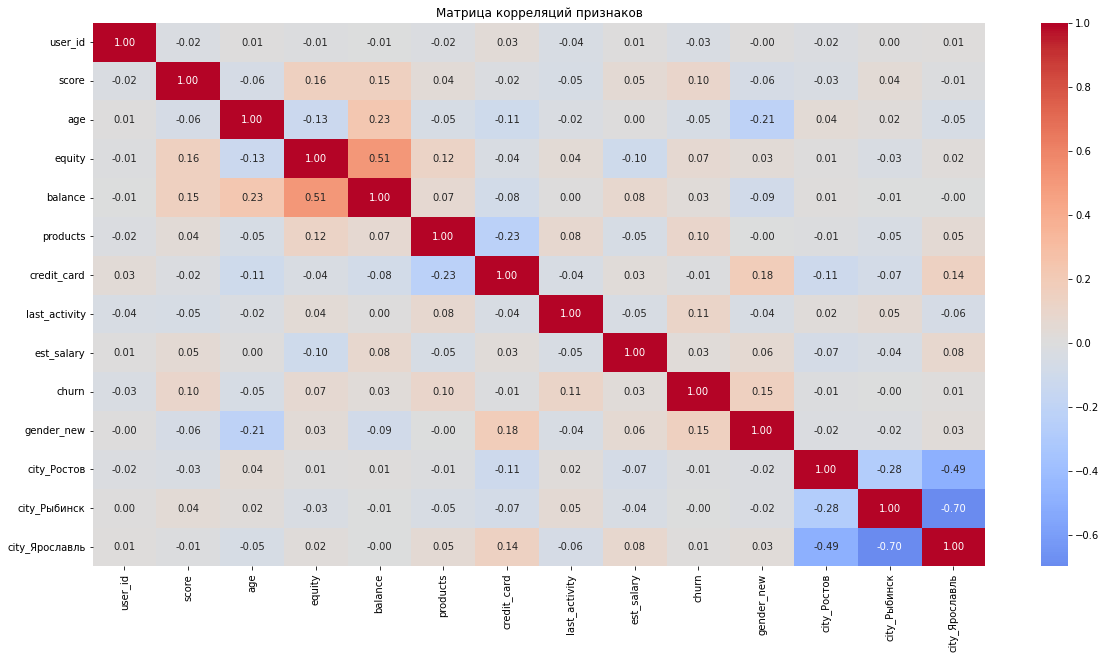

In [45]:
corr_data = data.drop(['gender','city_new'], axis=1).corr()

plt.figure(figsize=(20, 10))
plt.title('Матрица корреляций признаков')
ax=sns.heatmap(
    corr_data,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0
)
plt.show()

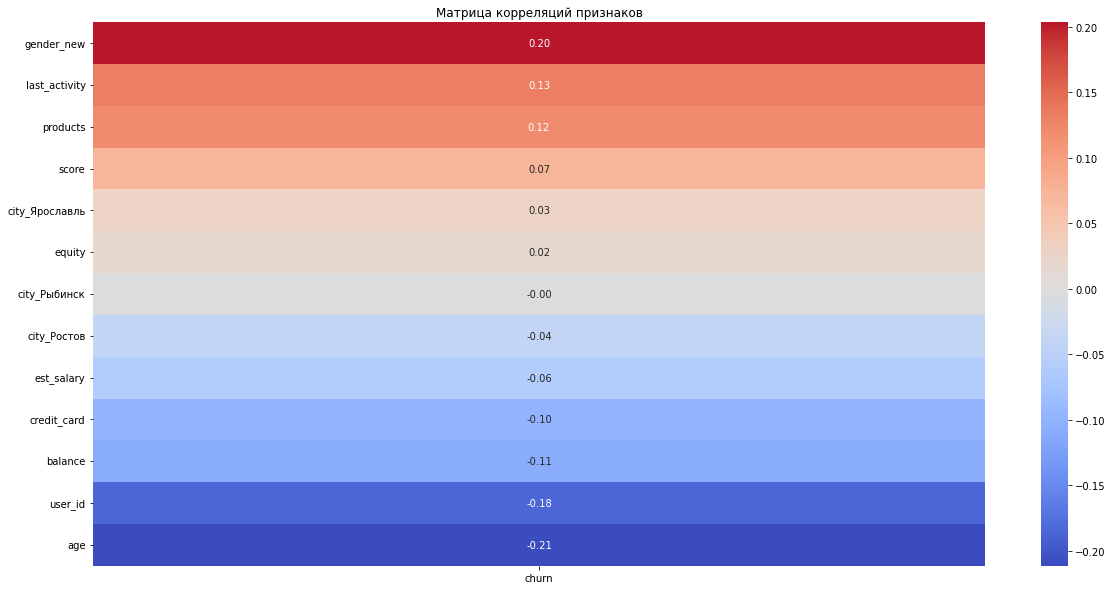

In [46]:
corr_data = data.drop(['gender','city_new'], axis=1).corr()

plt.figure(figsize=(20, 10))
plt.title('Матрица корреляций признаков')
ax=sns.heatmap(
    corr_data.corr()[['churn']].sort_values(by='churn',ascending=False).drop(['churn'], axis=0),
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0
)
plt.show()

Основные признаки, которые коррелируют с `churn` - это `products`, `last_activity`, `gender`.

По шкале Чеддока можно сказать, что у всех признаков слабая связь.




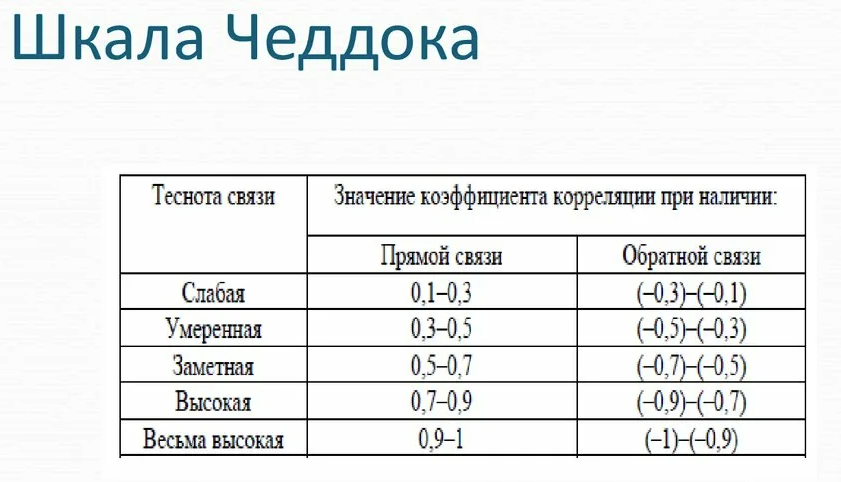

### Вывод

Из проведенного анализа можно составить примерный портрет клиента, который склонен к уходу из банка:


|       |     Портрет отточного клиента   |          
|:---:|:---:|
|Средняя запрлата|102385.774634|
|Средний возраст|39.61626|
|Средний доход|287614.294341|
|Медианная зарплата|92688.32|
|Медианный возраст|37.0|
|Медианный доход|296133.69|
|Медианное количество продуктов|2.0|
|Медианное количество собственности	|2.80813|
|Мода по городу|Ярославль|
|Мода по гендеру|М|
|Медиана по гендеру|1.0|
|Медиана по городу Ростов|0.0|
|Медиана по городу Рыбинск|0.0|
|Медиана по городу Ярославль|1.0|
|Кредитная карта| есть |
|Активность клиента| активный |

Основными признаками, которые коррелируют с оттоком - это `products`, `last_activity`, `gender`.

## 4. Статистические тесты

**Гипотеза 1**:

**H0**: доход клиентов, ушедших из банка **равен** доходу клиентов, оставшихся в банке

**H1**: доход клиентов, ушедших из банка **не равен** доходу клиентов, оставшихся в банке

In [47]:
sample_A = data.query('churn == 0')['est_salary']
sample_B = data.query('churn == 1')['est_salary']

In [48]:
print('Относительная разница средних : {0:.2%}'.format(sample_B.mean() / sample_A.mean() - 1))

Относительная разница средних : 4.14%


In [49]:
print('Размер 1й выборки:',len(sample_A))
print('Размер 2й выборки:',len(sample_B))

Размер 1й выборки: 3073
Размер 2й выборки: 615


In [50]:
alpha = 0.05  # критический уровень статистической значимости

In [51]:
def test(group):
    results = st.shapiro(group)
    p_value = results[1]
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: распределение не нормально')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

In [52]:
test(sample_A)

p-значение:  1.2976391459701858e-31
Отвергаем нулевую гипотезу: распределение не нормально


In [53]:
test(sample_B)

p-значение:  2.7330762949981893e-18
Отвергаем нулевую гипотезу: распределение не нормально


In [54]:
def disp(group):
    alpha = group.mean()
    results = variance(group)
    p_value = results
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Разброс данных приемлемый')
    else:
        print('Дисперсия высокая')

In [55]:
disp(sample_A)

p-значение:  3269389139.0551133
Дисперсия высокая


In [56]:
disp(sample_B)

p-значение:  3597242086.7861805
Дисперсия высокая


Посколько мы убрали аномальные значение, мы можем применить среднее распределение. Также мы выяснили, что есть относительная разница в выборках и их распредление не нормальное, поэтому воспользуемся критерием Манна-Уитни.

In [57]:
alpha = .05 

results = st.ttest_ind(
    sample_A, 
    sample_B,
    equal_var = False) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('t-критерий Стьюдента - Отвергаем нулевую гипотезу')
else:
    print('t-критерий Стьюдента - Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.12195639135611816
t-критерий Стьюдента - Не получилось отвергнуть нулевую гипотезу


In [58]:
results = st.mannwhitneyu(
    sample_A, 
    sample_B) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Тест "Манна-Уитни" - Отвергаем нулевую гипотезу')
else:
    print('Тест "Манна-Уитни" - Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.16281039621396964
Тест "Манна-Уитни" - Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть нулевую гипотезу. Это значит, что статистически значимых различий между средними двух выборок не было обнаружено.

**Гипотеза 2**:

**H0**: Количество женщин, ушедших из банка **равно** количеству мужчин, ушедших из банка

**H1**: Количество женщин, ушедших из банка **не равно** количеству мужчин, ушедших из банка


In [59]:
data.head()

user_id  score gender  age  equity    balance  products  credit_card  \
0    183012  850.0      Ж   25       1   59214.82         2            0   
4    157978  730.0      М   34       5     174.00         1            1   
6    177259  807.0      Ж   39       3  405042.44         3            0   
7    218868  825.0      Ж   38       4  458145.40         2            1   
13   166357  837.0      Ж   28       4  302249.22         2            0   

    last_activity  est_salary  churn  gender_new   city_new  city_Ростов  \
0               1    75719.14      1           0    Рыбинск            0   
4               0    67353.16      1           1  Ярославль            0   
6               1   103838.32      0           0  Ярославль            0   
7               1    68085.48      0           0  Ярославль            0   
13              1    30950.94      0           0    Рыбинск            0   

    city_Рыбинск  city_Ярославль  
0              1               0  
4              0               1  
6              0               1  
7              0               1  
13             1               0

In [60]:
sample_A = data.query('churn == 1 & gender_new == 0')['gender_new']
sample_B = data.query('churn == 1 & gender_new == 1')['gender_new']

In [61]:
print('Размер 1й выборки:',len(sample_A))
print('Размер 2й выборки:',len(sample_B))

Размер 1й выборки: 218
Размер 2й выборки: 397


In [62]:
test(sample_A)

p-значение:  1.0
Не получилось отвергнуть нулевую гипотезу, всё нормально


In [63]:
test(sample_B)

p-значение:  1.0
Не получилось отвергнуть нулевую гипотезу, всё нормально


In [64]:
alpha = .05 

results = st.ttest_ind(
    sample_A, 
    sample_B,
    equal_var = False) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('t-критерий Стьюдента - Отвергаем нулевую гипотезу')
else:
    print('t-критерий Стьюдента - Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.0
t-критерий Стьюдента - Отвергаем нулевую гипотезу


In [65]:
results = st.mannwhitneyu(
    sample_A, 
    sample_B) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.519957875639791e-135
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу. Это значит, что есть статистически значимые различия между средними двух выборок.

## 5. Сегментация 

Сегменты наиболее склонные к оттоку выберем по трем основным признакам - `products`, `last_activity`, `gender`.

`1 сегмент`:
- score от 770 до 890, есть активность, 30-40 лет

`2 сегмент`:
- от 2х и более продукта, мужчины, есть кредитка, из Ярославля

`3 сегмент`:
- от 2х и более продукта, зарплата от 50к до 150к, баланс от 200к до 400к, от 3х и более объекта жилья

In [66]:
segment1 = data.query('score >= 770 & score <= 890 & last_activity == 1  & age >=30 & age <= 40')

In [67]:
print('Количество клиентов в сегменте: ',segment1['user_id'].nunique())

Количество клиентов в сегменте:  578


In [68]:
segment1_chrn = (segment1.pivot_table(index='churn', values='last_activity', aggfunc='count')
             .rename(columns={'last_activity':'count'})).reset_index()
segment1_chrn['percent'] = round((segment1_chrn['count'] / segment1_chrn['count'].sum() *100),2)
segment1_chrn

churn  count  percent
0      0    455    78.72
1      1    123    21.28

In [69]:
fig = px.pie(segment1_chrn, values='count', names='churn')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide',
                  title = 'Cоотношение оттока клиентов 1 сегмента',
                  title_font_size=15,
                  title_x=0.5)
fig.show()

In [70]:
segment2 = data.query('products >= 2 & gender_new == 1 & credit_card == 1 & city_new == "Ярославль"')

In [71]:
print('Количество клиентов в сегменте: ',segment2['user_id'].nunique())

Количество клиентов в сегменте:  617


In [72]:
segment2_chrn = (segment2.pivot_table(index='churn', values='last_activity', aggfunc='count')
             .rename(columns={'last_activity':'count'})).reset_index()
segment2_chrn['percent'] = round((segment2_chrn['count'] / segment2_chrn['count'].sum() *100),2)
segment2_chrn

churn  count  percent
0      0    480     77.8
1      1    137     22.2

In [73]:
fig = px.pie(segment2_chrn, values='count', names='churn')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide',
                  title = 'Cоотношение оттока клиентов 2 сегмента',
                  title_font_size=15,
                  title_x=0.5)
fig.show()

In [74]:
segment3 = data.query('products >= 2 &  est_salary >= 50000 & est_salary <= 150000  & equity >= 3 & balance >= 200000 & balance <= 400000')

In [75]:
print('Количество клиентов в сегменте: ',segment3['user_id'].nunique())

Количество клиентов в сегменте:  498


In [76]:
segment3_chrn = (segment3.pivot_table(index='churn', values='last_activity', aggfunc='count')
             .rename(columns={'last_activity':'count'})).reset_index()
segment3_chrn['percent'] = round((segment3_chrn['count'] / segment3_chrn['count'].sum() *100),2)
segment3_chrn

churn  count  percent
0      0    408    81.93
1      1     90    18.07

In [77]:
fig = px.pie(segment3_chrn, values='count', names='churn')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide',
                  title = 'Cоотношение оттока клиентов 3 сегмента',
                  title_font_size=15,
                  title_x=0.5)
fig.show()

### 5.1 Приоретизация сегментов



Приоритезацию будем делать по трем признакам:
1) Количество человек в сегменте

2) Процент оттока

3) Уникальные признаки

In [78]:
piority_segment = pd.DataFrame({'index' : [
        'Количество человек в сегменте',
        'Процент оттока,%',
        'Уникальные признаки'],
    
    'Сегмент 1': [segment1_chrn['count'].sum(),
                                 segment1_chrn['percent'][1], 2],
                       
    'Сегмент 2': [segment2_chrn['count'].sum(),
                                 segment2_chrn['percent'][1], 3],
    'Сегмент 3': [segment3_chrn['count'].sum(),
                                 segment3_chrn['percent'][1], 3]                          
 }
    

)

In [79]:
piority_segment

index  Сегмент 1  Сегмент 2  Сегмент 3
0  Количество человек в сегменте     578.00      617.0     498.00
1               Процент оттока,%      21.28       22.2      18.07
2            Уникальные признаки       2.00        3.0       3.00

Приоритезировать сегменты будем таким образом `Сегмент2`, `Сегмент1`, `Сегмент3`. Потому что во втором сегменте больше количество человек и больше уникальных признаков, что позволяет сделать узкий охват наших клиентов и если этот сегмент не сработает, перейти к следующему.


## Общий вывод

В данном исследовании были выявлены некоторые особенности:
1) Были выявлены аномальные значения в балансе более 50млн

2) Были выявлены аномальные значения в зарплате более 1млн

Данных клиентов можно отнести к премиум клиентам, но эти шейхи влияли на наши исследования по средним клиентам.

3) `17%` клиентов из банка ушли, давольно печальный показатель

Значения не сильньно выбиваются друг от друга, выделяется количество объектов и количество продуктов - чем их больше, тем больший % клиентов ушел

Многие показатели оттока выше или около среднебанковского, можно выделить отдельно те признаки, которые вышли за пороговое значение:
- Количество собвественности:
    - 5 - `23%`
    - 6 - `26%`
    - 7 - `37%`
    - 8 - `20%`
    - 9 - `100%`
    
- Количество продуктов:
    - 3 - `23%`
    - 4 - `45%`
    
- Есть кредитная карта, отток - в любых вариациях около `17%`
    
- Активный клиент, отток - `20.8%`
    
- Мужчина, отток - `22.7%`
    
- Ярославль, отток - `17.1%`. Но в целом по всем городам отток приближен к общебанковскому.



Из проведенного анализа можно составить примерный портрет клиента, который склонен к уходу из банка:


|       |     Портрет отточного клиента   |          
|:---:|:---:|
|Средняя запрлата|102385.774634|
|Средний возраст|39.61626|
|Средний доход|287614.294341|
|Медианная зарплата|92688.32|
|Медианный возраст|37.0|
|Медианный доход|296133.69|
|Медианное количество продуктов|2.0|
|Медианное количество собственности	|2.80813|
|Мода по городу|Ярославль|
|Мода по гендеру|М|
|Медиана по гендеру|1.0|
|Медиана по городу Ростов|0.0|
|Медиана по городу Рыбинск|0.0|
|Медиана по городу Ярославль|1.0|
|Кредитная карта| есть |
|Активность клиента| активный |

Основными признаками, которые коррелируют с оттоком - это `products`, `last_activity`, `gender`.

Было выделено 3 сегмента 

`1 сегмент`:
- score от 770 до 890, есть активность, 30-40 лет

`2 сегмент`:
- от 2х и более продукта, мужчины, есть кредитка, из Ярославля

`3 сегмент`:
- от 2х и более продукта, зарплата от 50к до 150к, баланс от 200к до 400к, от 3х и более объекта жилья


Приоретизировали по следующим признакам:


|       |     Сегмент 1    |     Сегмент 2    |     Сегмент 3 |     
|:---:|:---:|:---:|:---:|
|     Количество человек в сегменте    |     578    |     617    |   498    |
|     Процент оттока,%    |     21.28 %    |     22.2 %    |  18.07 %    |  
|     Уникальные признаки    |     2    |     3    |    3    |  


Отделу маркетинга могу выделить несколько рекомендаций:

`1й сегмент`

Необходимо провести дополнительное исследование для данной возрастной группы, какие сейчас тенденции и что им может быть интересно, возможно наш банк делает упор на молодежь и проявляет меньше лояльности к средней возрастной группе.

`2й сегмент`

Необходимо изучить рынок Ярославля, кто наши конкуренты и почему клиенты от нас уходят, возможно стоит посмотреть со стороны особенности региона, а не делать упор на обще масс.

`3й сегмент`

В третьем сегменте много объектов недвижимости, со средней зарплатой по Москве, но выше среднего по нашим регионам, плюс есть накопления на счету. следует это учесть, например если банк делает спец. предложения по ипотеке для новостроек, возможно это не устраивает клиентов, у которых уже есть недвижимость. Может быть стоить пересмотреть условия страхования жилья и сделать более выгодные условия для нашего сегмента. Также стоит предложить выгодные условия по открытию вкладов, чтобы сохранить сбережения внашем банке.
